In [3]:
import pandas as pd


df = pd.read_csv('compiled_optimization_data.csv')
BO_cols = ['sample','beta','conductivity_avg','DMSO_content_realized','concentration_realized','combustion_temp_realized','air_flow_rate_realized','spray_flow_rate_realized','spray_height_realized','num_passes_realized']
BO_data = df[BO_cols]
BO_data['scaled_conductivity_avg'] = BO_data['conductivity_avg'] * 1e-6 # Scaling the conductivity as it is reported in the paper
display(BO_data)

features = ['DMSO_content_realized', 'concentration_realized',
            'combustion_temp_realized', 'air_flow_rate_realized',
            'spray_flow_rate_realized', 'spray_height_realized', 'num_passes_realized']

target = 'scaled_conductivity_avg' # Using the scaled as y

# Data processcing
X = BO_data[features]
y = BO_data[target]

/var/folders/tn/_5w3fjw13jn7qf4h0l1cqc040000gn/T/ipykernel_9872/549811159.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BO_data['scaled_conductivity_avg'] = BO_data['conductivity_avg'] * 1e-6 # Scaling the conductivity as it is reported in the paper


,sample,beta,conductivity_avg,DMSO_content_realized,concentration_realized,combustion_temp_realized,air_flow_rate_realized,spray_flow_rate_realized,spray_height_realized,num_passes_realized,scaled_conductivity_avg
0,0,random,1.749261e+06,0.303015,0.016717,275.376821,77.257211,0.006671,17.859245,8.0,1.749261
1,1,random,1.848613e+06,0.316566,0.016290,271.445423,77.257211,0.006671,17.859245,8.0,1.848613
2,2,random,1.156030e+06,0.110944,0.015141,247.327137,94.389907,0.004694,18.015901,5.0,1.156030
3,3,random,1.267199e+06,0.102290,0.015162,249.043556,94.389907,0.004694,18.015901,5.0,1.267199
4,4,random,0.000000e+00,0.142058,0.014216,227.253349,65.455738,0.002899,21.505628,4.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
172,175,4.00E+02,8.775937e+05,0.124872,0.010071,226.501728,100.000000,0.002000,10.000000,1.0,0.877594
173,176,4.00E+02,1.089103e+06,0.126204,0.009938,230.296026,100.000000,0.002000,10.000000,1.0,1.089103
174,177,SF,0.000000e+00,0.160652,0.019693,289.655893,92.976613,0.007983,18.878692,10.0,0.000000
175,178,SF,0.000000e+00,0.162428,0.019463,289.378096,92.976613,0.007983,18.878692,10.0,0.000000


## Hypothesis testing
- t-test
- permutation test

In [10]:
BO_data['beta'].unique()

random = BO_data[BO_data['beta'] == 'random']['scaled_conductivity_avg']
space_fill = BO_data[BO_data['beta'] == 'SF']['scaled_conductivity_avg']
UCB_0_2 = BO_data[BO_data['beta'] == '2.00E-01']['scaled_conductivity_avg']
UCB_20 = BO_data[BO_data['beta'] == '2.00E+01']['scaled_conductivity_avg']
UCB_400 = BO_data[BO_data['beta'] == '4.00E+02']['scaled_conductivity_avg']

In [28]:
from scipy.stats import ttest_ind
comparisons = [
    ('SF', space_fill),
    ('2.00E-01', UCB_0_2),
    ('2.00E+01', UCB_20),
    ('4.00E+02', UCB_400)
]

# Perform t-test for each comparison
ttest_results = []
for label, group in comparisons:
    t_stat, p_value = ttest_ind(group, random, alternative='greater')
    ttest_results.append({
        'Comparison': f'{label} vs random',
        't-statistic': round(t_stat, 2),
        'p-value': round(p_value, 4)
    })

# Create a DataFrame to store the results
results_df = pd.DataFrame(ttest_results)

# Display the results
print(results_df)

           Comparison  t-statistic  p-value
0        SF vs random        -1.32   0.9048
1  2.00E-01 vs random        11.42   0.0000
2  2.00E+01 vs random        12.73   0.0000
3  4.00E+02 vs random         1.21   0.1151


In [13]:
import numpy as np

def permutation_test_max(group1_label, group2_label, n_permutations=10000, df=BO_data):
    X = df[df['beta'] == group1_label][['scaled_conductivity_avg']].to_numpy()
    Y = df[df['beta'] == group2_label][['scaled_conductivity_avg']].to_numpy()

    np.random.seed(0)
    combined = np.concatenate([X, Y])
    n = len(X)
    obs_diff = np.max(X) - np.max(Y)
    
    perm_diffs = []
    for _ in range(n_permutations):
        np.random.shuffle(combined)
        X_permuted = combined[:n]
        Y_permuted = combined[n:]
        max_diff = np.max(X_permuted) - np.max(Y_permuted)
        perm_diffs.append(max_diff)
    
    # Calculate the p-value
    p_value = np.mean(perm_diffs > obs_diff)
    
    return np.array(perm_diffs), obs_diff, p_value

In [15]:
random_label = 'random'
comparisons = ['SF', '2.00E-01', '2.00E+01', '4.00E+02']

perm_results = []

# Run permutation test for each comparison
for comp in comparisons:
    perm_diffs, obs_diff, p_value = permutation_test_max(group1_label=comp, group2_label=random_label, n_permutations=10000)
    perm_results.append({
        'Comparison': f'{comp} vs random',
        'Observed Max Difference': round(obs_diff, 3),
        'p-value': round(p_value, 4)
    })

perm_results_df = pd.DataFrame(perm_results)
print(perm_results_df)

           Comparison  Observed Max Difference  p-value
0        SF vs random                    0.004   0.3608
1  2.00E-01 vs random                    0.994   0.0000
2  2.00E+01 vs random                    0.812   0.0000
3  4.00E+02 vs random                   -0.003   0.5592


## VARS

In [31]:
from varstool import DVARS
vars_data = BO_data.drop(columns=['sample','beta','conductivity_avg'])
display(vars_data)


display(vars_data)
vars_data.to_csv('vars_data.csv', index=False)
h = 0.5
experiment = DVARS(data_file = 'vars_data.csv',
                   outvarname = 'scaled_conductivity_avg',
                   ivars_range = h,
                   phi0=1,
                   phi_max=1e6,
                   tol = 1e-6,
                   correlation_func_type='linear',
                   report_verbose=False)

experiment.run()
display(experiment.ratios)

,DMSO_content_realized,concentration_realized,combustion_temp_realized,air_flow_rate_realized,spray_flow_rate_realized,spray_height_realized,num_passes_realized,scaled_conductivity_avg
0,0.303015,0.016717,275.376821,77.257211,0.006671,17.859245,8.0,1.749261
1,0.316566,0.016290,271.445423,77.257211,0.006671,17.859245,8.0,1.848613
2,0.110944,0.015141,247.327137,94.389907,0.004694,18.015901,5.0,1.156030
3,0.102290,0.015162,249.043556,94.389907,0.004694,18.015901,5.0,1.267199
4,0.142058,0.014216,227.253349,65.455738,0.002899,21.505628,4.0,0.000000
...,...,...,...,...,...,...,...,...
172,0.124872,0.010071,226.501728,100.000000,0.002000,10.000000,1.0,0.877594
173,0.126204,0.009938,230.296026,100.000000,0.002000,10.000000,1.0,1.089103
174,0.160652,0.019693,289.655893,92.976613,0.007983,18.878692,10.0,0.000000
175,0.162428,0.019463,289.378096,92.976613,0.007983,18.878692,10.0,0.000000


,DMSO_content_realized,concentration_realized,combustion_temp_realized,air_flow_rate_realized,spray_flow_rate_realized,spray_height_realized,num_passes_realized,scaled_conductivity_avg
0,0.303015,0.016717,275.376821,77.257211,0.006671,17.859245,8.0,1.749261
1,0.316566,0.016290,271.445423,77.257211,0.006671,17.859245,8.0,1.848613
2,0.110944,0.015141,247.327137,94.389907,0.004694,18.015901,5.0,1.156030
3,0.102290,0.015162,249.043556,94.389907,0.004694,18.015901,5.0,1.267199
4,0.142058,0.014216,227.253349,65.455738,0.002899,21.505628,4.0,0.000000
...,...,...,...,...,...,...,...,...
172,0.124872,0.010071,226.501728,100.000000,0.002000,10.000000,1.0,0.877594
173,0.126204,0.009938,230.296026,100.000000,0.002000,10.000000,1.0,1.089103
174,0.160652,0.019693,289.655893,92.976613,0.007983,18.878692,10.0,0.000000
175,0.162428,0.019463,289.378096,92.976613,0.007983,18.878692,10.0,0.000000


,DMSO_content_realized,concentration_realized,combustion_temp_realized,air_flow_rate_realized,spray_flow_rate_realized,spray_height_realized,num_passes_realized
0.5,0.302439,0.294266,0.118195,0.027365,0.049267,0.150599,0.05787


ARD

In [57]:
import torch
import botorch as bo
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_mll

# Features and target variable
features = ['DMSO_content_realized', 'concentration_realized',
            'combustion_temp_realized', 'air_flow_rate_realized',
            'spray_flow_rate_realized', 'spray_height_realized', 'num_passes_realized']

target = 'scaled_conductivity_avg'  # Target variable (scaled)

# Data processing: normalize X, standardize y
X = BO_data[features]
y = BO_data[target]
std = 0.1

X_tensor = torch.tensor(X.values, dtype=torch.double)
y_tensor = torch.tensor(y.values, dtype=torch.double)

# Now use the full dataset
X_full = X_tensor
Y_full = y_tensor
train_Yvar = torch.full_like(Y_full.unsqueeze(-1), std)

model = bo.models.SingleTaskGP(X_full, Y_full.unsqueeze(-1))
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_mll(mll)

/Users/dylanschubert/anaconda3/envs/msc_project/lib/python3.12/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/dylanschubert/anaconda3/envs/msc_project/lib/python3.12/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.6009], dtype=torch.float64), std = tensor([1.5127], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): MaternKernel(
        (lengthscale_prior): GammaPrior()
        (raw_lengthscale_constraint): Positive()
      )
      (outputscale_prior): GammaPrior()
      (raw_outputscale_constraint): Positive()
    )
  )
)

In [58]:
lengthscales = model.covar_module.base_kernel.lengthscale.squeeze().cpu().detach().numpy()
rel_ARD = np.zeros(7)
rel_ARD += 1 / lengthscales
rel_ARD_nor = rel_ARD/np.max(rel_ARD)
print(rel_ARD)
print(rel_ARD_nor)

[24.89565699  2.75645001  0.1551961   0.60201444  2.9624827   2.81564575
  0.9254084 ]
[1.         0.11072012 0.00623386 0.0241815  0.11899596 0.11309787
 0.03717148]


Plots

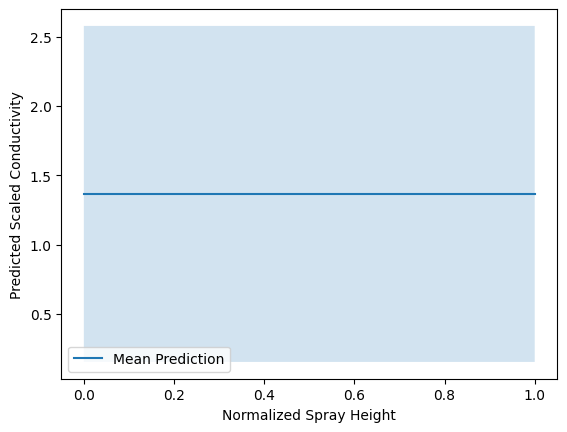

In [61]:

constant_features = {
      'DMSO_content_realized': 0.5,
      'concentration_realized': 0.5,
      'combustion_temp_realized': 0.5,
      'air_flow_rate_realized': 0.5,
      'spray_flow_rate_realized': 0.5,
      'num_passes_realized': 0.5}

num = 1000
constant_features_tensor = torch.zeros((num, len(features)), dtype=torch.double)
spray_height_values = torch.linspace(0, 1, num).unsqueeze(1)

for i, feat in enumerate(features):
    if feat == 'spray_height_realized': # Feature here
        constant_features_tensor[:, i] = spray_height_values.squeeze()
    else:
        constant_features_tensor[:, i] = constant_features[feat]

with torch.no_grad():
    pred = model.posterior(constant_features_tensor)
    mean = pred.mean
    st = pred.variance.sqrt()

# Plot the results
plt.figure()
plt.plot(spray_height_values.numpy(), mean.numpy(), label='Mean Prediction')
plt.fill_between(spray_height_values.numpy().squeeze(),
                     (mean - st).numpy().squeeze(),
                     (mean + st).numpy().squeeze(),
                     alpha=0.2)

plt.xlabel('Normalized Spray Height')
plt.ylabel('Predicted Scaled Conductivity')
plt.legend()

plt.show()